# Lecture 3.9: Support Vector Machines (SVMs)

[**Lecture Slides**](https://docs.google.com/presentation/d/1YHlLETqoquGgoYOZTzHdrZ32cnmZKT0YmnGBr_bYHWI/edit?usp=sharing)

This lecture, we are going to train and compare a logistic regression model, a linear kernel SVM, and a radial basis function (RBF) kernel SVM on a real dataset.

**Learning goals:**
- train a linear kernel SVM
- train a RBF kernel SVM
- visualize and compare the model decision boundaries
- analyse the effect of regularization parameters $C$ & $\gamma$

## 1. Introduction

An estimated [\$70 million](https://en.wikipedia.org/wiki/Counterfeit_United_States_currency) in counterfeit bills are currently in circulation in the USA. That's quite a hustle 😎💰. The Federal Reserve doesn't like it however, and wants our help detecting fake banknotes. This can be a hard task: tiny defects are tough to spot, and counterfeiters constantly change their techniques. 

Machine Learning models can help, because they performs particularly well on unseen data. The [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication) frames this challenge as a binary classification task.  Let's compare the predictions of logistic regression and SVMs on this fake/genuine banknote dataset.

## 2. Data Munging

### 2.1 Data Exploration
Let's load our `.csv` into a pandas `DataFrame`, and have a look at the dataset:

In [1]:
import pandas as pd

df = pd.read_csv('bank_note.csv')

df.head()

,feature_1,feature_2,feature_3,feature_4,is_fake
0,1.121806,1.149455,-0.975970,0.354561,0
1,1.447066,1.064453,-0.895036,-0.128767,0
2,1.207810,-0.777352,0.122218,0.618073,0
3,1.063742,1.295478,-1.255397,-1.144029,0
4,-0.036772,-1.087038,0.736730,0.096587,0


In [2]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,is_fake
count,1372.000000,1.372000e+03,1.372000e+03,1.372000e+03,1372.000000
mean,0.000000,4.143106e-17,1.035777e-17,-5.437827e-17,0.444606
std,1.000365,1.000365e+00,1.000365e+00,1.000365e+00,0.497103
min,-2.630737,-2.675252e+00,-1.551303e+00,-3.502703e+00,0.000000
25%,-0.776547,-6.188189e-01,-6.899455e-01,-5.817379e-01,0.000000
50%,0.021974,6.771828e-02,-1.812706e-01,2.880644e-01,0.000000
75%,0.840243,8.338757e-01,4.135174e-01,7.553713e-01,1.000000
max,2.249008,1.879908e+00,3.836586e+00,1.733680e+00,1.000000


Each row is a banknote example, and there are four numerical features, `feature_i`, and one binary label, `is_fake`. It might be surprising that these examples aren't images. Instead, they are [wavelet transforms](https://en.wikipedia.org/wiki/Wavelet_transform) of the banknote pictures.

All four features have $mean = 0$ and $std = 1$ : they have already been standardized. The `count` row of the summary statistic table shows that there are no missing values. This means no further data preprocessing is necessary, and we can directly train our classifiers. 🏃‍♂️

### 2.2 Feature Matrix

We want to pick two out of the four features. This will allow the visualization of the models, without resorting to dimensionality reduction techniques like PCA. Ideally, we would use a [feature selection](https://machinelearningmastery.com/an-introduction-to-feature-selection/) technique to choose the best two columns. However this is a lecture on SVMs and not feature selection, so I've saved us some time and found that `feature_2` and `feature_4` will work well for this example.

We can therefore select those columns and store them in our feature matrix. The `is_fake` column will be used as label vector:

In [3]:
X = df[['feature_2', 'feature_4']].values
y = df['is_fake'].values

### 2.3 Data Visualization

We can now visualize the dataset to get an idea of the _topology_ of the data. i.e We want to assess the _complexity_ of the task.

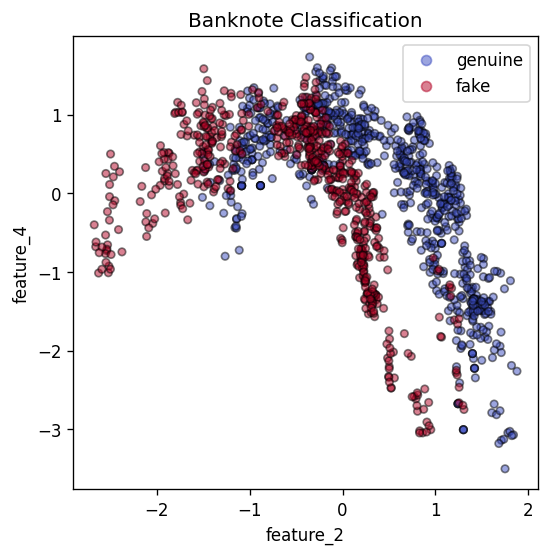

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5), dpi=120)
ax = fig.add_subplot()

scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlabel('feature_2')
ax.set_ylabel('feature_4')
ax.set_title('Banknote Classification')
handles, labels = scatter.legend_elements()
ax.legend(handles=handles, labels=['genuine', 'fake']);

We can see four oblong shaped clusters of `fake` and `genuine` banknotes. These clusters overlap, meaning the data is _not separable_ . Moreover, the relationship between `feature_2` and `feature_4` is _non-linear_. There is therefore no perfect way of predicting the `is_fake` label, and a linear decision boundary will struggle to be accurate. This a great task to demonstrate the non-linear power of our RBF kernel SVM!

## 3. Training


### 3.1 Logistic Regression

We know that this problem is non-linear, but let's build from the ground up with a linear classifier: our trusted logistic regression. As always, we use sklearn and its model api. We train the model with the `.fit()` method:

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X, y)

As in notebook 3.6, we can take a look at the model parameters, $\theta$:

In [6]:
import numpy as np

theta = np.append(lr.intercept_, lr.coef_)
theta

array([-0.18560703, -1.89956303, -1.0847717 ])

These $\theta$ values shape the model's decision boundary. We'd like to visualize this along with the dataset. Since we'll be visualizing a lot of classifications in 2D throughout this notebook, let's write some helper functions (code from the [sklearn documentation](https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html)).

The function `.plot_classification()` plots both the dataset and the decision boundary for a given feature matrix `X`, label vector `y`, and a classifier `clf`:

In [7]:
import numpy as np
from matplotlib.lines import Line2D

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_decision_boundary(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_margin(ax, clf, xx, yy, **params):
    """Plot the margin for a large margin classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a large margin classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contour(xx, yy, Z, levels=[-1, 0, 1],
           linestyles=['--', '-', '--'], **params)
    return out

def plot_contours(ax, clf, xx, yy, margin, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    plot_decision_boundary(ax, clf, xx, yy, **params)
    if margin:
        plot_margin(ax, clf, xx, yy, colors='w', alpha=0.7)


def plot_classification(ax, X, y, clf, margin=False):
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, margin,
                      cmap=plt.cm.coolwarm, alpha=0.8)
    scatter = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=1.0)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Bank Notes Classification')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=['genuine', 'fake'])

We can now easily plot our logistic regression classifier's predictions 🎨:

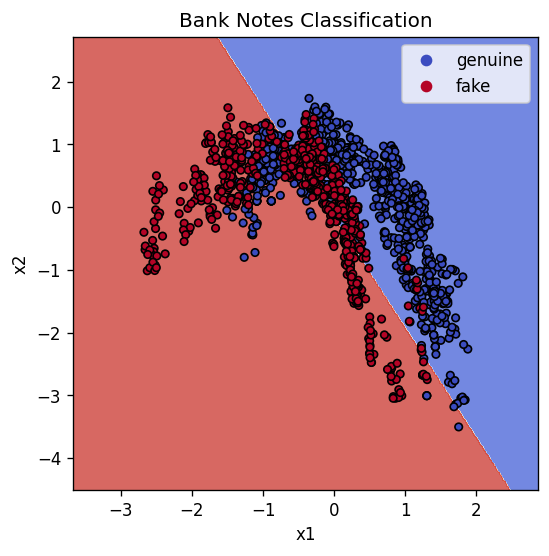

In [8]:
fig = plt.figure(figsize=(5,5), dpi=120)
ax = fig.add_subplot()
plot_classification(ax, X, y, lr)

The color of the data points represent the _labels_ , the color of the background show the _predictions_. i.e the decision boundary is the edge between the red and blue background.

As expected, the linear model fits this data poorly: it fails to correctly predict the labels of many examples. Before we move on to non-linear models however, let's try another linear decision boundary: the linear kernel SVM.

### 3.2 Linear Kernel SVM

sklearn also uses the model api for SVMs. The `SVC` (support vector classifier) constructor takes in a `kernel` argument: in our case, we'll use a `linear` kernel function. This way, we won't add any extra non-linear feature dimensions to the hypothesis, and the decision boundary will be a straight line. Let's train the model with the `.fit()` method and our prepared feature matrix, `X`, and label vector, `y`:

In [9]:
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear', random_state=0)
svm_linear = svm_linear.fit(X, y)

We've trained our first support vector machine! 🎊 We can check out the optimized model parameters, $\theta$:

In [10]:
theta = np.append(svm_linear.intercept_, svm_linear.coef_)
theta

array([ 0.0041986 , -1.67054415, -0.94735934])

There are 3 model parameters: one intercept, $\theta_{0}$, and one coefficient per feature, $\theta_{1}$ & $\theta_{2}$. This makes sense since the linear kernel doesn't add extra feature dimensions.

Notice these values of $\theta$ are different than the logistic regression $\theta$. This means that the _orientation_ and _position_ of the decision boundary line will be (slightly) different.

🧠 Why does the linear kernel SVM find different optimal model parameters than logistic regression?

We can also take a look at our model's _support vectors_. Recall from the slides, that these are the examples near the _margin_ , which determine the shape of the decision boundary.

In [ ]:
print(f'The first support vector is {svm_linear.support_vectors_[0]}')
print(f'There are {len(svm_linear.support_vectors_)} support vectors.')

Each support vector is a 2 dimensional vector and corresponds to one example close to the margin. Notice that there are 807 support vectors, many more than the graphs from the lecture slides! 😧This is because this dataset is _non-separable_. The linear decision boundary cannot "cleanly" split the data points, and many of them end up inside the margin. We can visualize this directly:

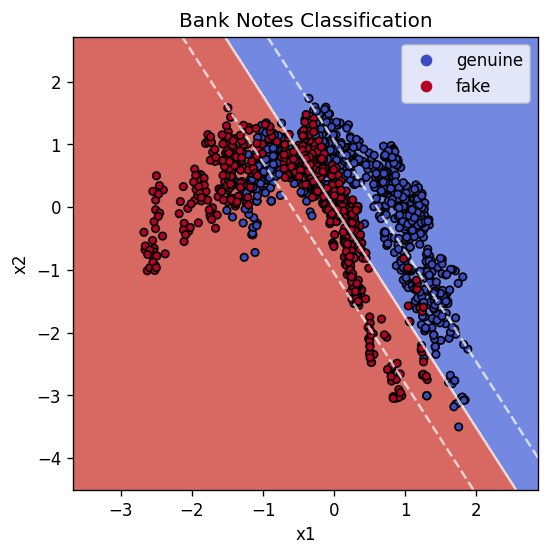

In [11]:
fig = plt.figure(figsize=(5,5), dpi=120)
ax = fig.add_subplot()
plot_classification(ax, X, y, svm_linear, margin=True)

The 807 support vectors are sitting inside the dotted margin, and thus this is a _soft margin_. The decision boundary is very similar to the logistic regression model, and the linear kernel SVM hasn't improved the predictions much. 😕 Large margin linear classifiers shine when the data is _separable_ , and we can see here that there isn't a maximal margin which "cleanly" separates the data.

Instead of using a _linear_ kernel, let's use the _RBF_ kernel to try classify these overlapping clusters of data points with a non-linear decision boundary. ➰

### 3.3 RBF Kernel SVM

We'll still use the `SVC` class, but this time with the `kernel='rbf'` argument.

In [12]:
from sklearn.svm import SVC

svm_rbf = SVC(kernel='rbf', random_state=0)
svm_rbf = svm_rbf.fit(X, y)

Kernels define extra feature dimensions in a different way to regression methods, so the hypothesis is a little more complicated than our usual $h_{\theta}(\textbf{x}) = f(\theta \textbf{x}$). Therefore, we can't directly access the model parameters of our RBF SVM.

In [ ]:
# this fails
# svm_rbf.coef_

We can still list the support vectors which affect the decision boundary:

In [13]:
len(svm_rbf.support_vectors_)

617

The number of support vectors has changed compared to the linear SVM, because the shape of the decision boundary and its margin has changed. We can visualize those with our helper functions:

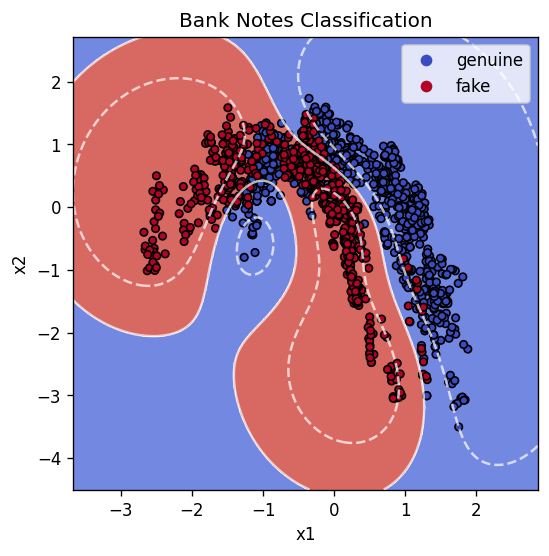

In [14]:
fig = plt.figure(figsize=(5,5), dpi=120)
ax = fig.add_subplot()
plot_classification(ax, X, y, svm_rbf, margin=True)

What a masterpiece! 👩‍🎨 There's a lot going on here, so let's break it down again:
- the red/blue points are the examples and their fake/genuine label
- the red/blue background are the fake/genuine predictions
- the full white line is the non-linear decision boundary
- the dotted lines are the margin

The margin and the decision boundary "curls" on itself to form several "blobs". This is the advantage of the rbf kernels, whose non-linear "distance" features can follow the shape of the dataset.

🧠 Try to keep track of which margin corresponds to which decision boundary, and how the margin width varies throughout the graph. Can you tell which examples are the 617 support vectors? Take your time to think about this graph, it should be clear how this relates the model's decision boundary, its predictions, and the data set.

This model's prediction look more accurate, but let's compare them side-by-side.

### 3.4 Comparison

We can write another helper function to juxtapose the classification graphs:

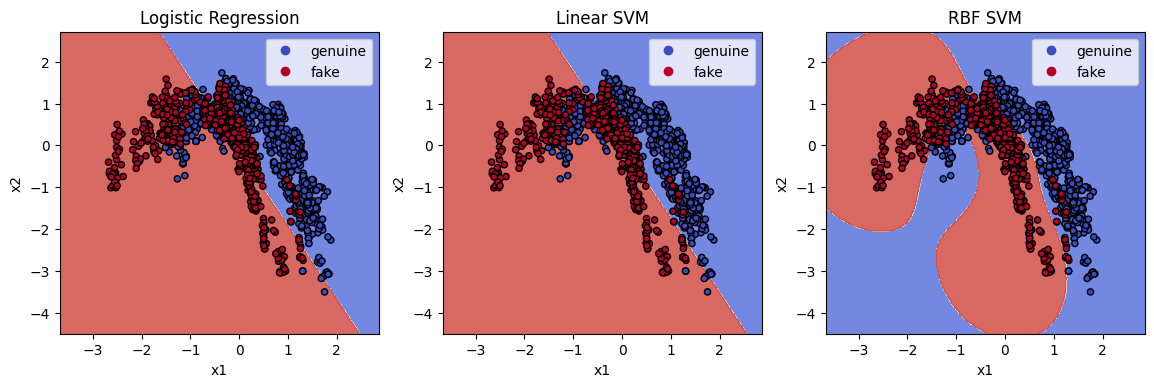

In [15]:
def plot_comparison(X, y, clfs, titles, margin=False):
    fig = plt.figure(figsize=(14, 4), dpi=100)
    for i, clf in enumerate(clfs):
        ax = fig.add_subplot(1, len(clfs), i+1)
        plot_classification(ax, X, y, clf, margin)
        ax.set_title(titles[i])

plot_comparison(X, y, [lr, svm_linear, svm_rbf], ['Logistic Regression', 'Linear SVM', 'RBF SVM'])

We can now clearly see that linear models fail to predict many of the labels accurately, whilst the non-linear RBF kernel SVM has more success fitting the mixed clusters.

## 4. Prediction

In classification, predictions are determined by decision boundaries. Hence our RBF SVM should _predict_ differently than the other two models in some areas of the _feature space_. Let's classify a banknote located right in the small `genuine` cluster on the left hand side of the graphs above.  We'll use $feature\_1 = -1; feature\_2 = 0$:

In [ ]:
x_predict = np.array([-1, 0]).reshape(1, 2)
print(f'Features: {x_predict}')

lr_prediction = lr.predict(x_predict)
print(f'Logistic Regression prediction: {lr_prediction}')

svm_linear_prediction = svm_linear.predict(x_predict)
print(f'Linear SVM prediction: {svm_linear_prediction}')

svm_rbf_prediction = svm_rbf.predict(x_predict)
print(f'RBF SVM prediction: {svm_rbf_prediction}')

The RBF kernel SVM accurately classifies the banknote as `genuine`, whereas the other two models fail.

🧠 Why was the RBF kernel SVM the only model making the correct prediction here?

Answer : Because it's the only model that has used a non-linear approach and classified the area x(-1,0) correctly.

## 5. Analysis

We have tried different SVM kernels, but haven't played with the other two model hyperparameters: $C$, and $\gamma$. Both of these control regularization, and regularization affects generalization, so it's important to find their optimal value.

### 5.1 Regularization: C

$C$ control the _width_ of the margin. Since the margin dictates the support vectors, and the support vectors shape the decision boundary, changing $C$ affects the entire model. It's not easy to imagine how this looks! Let's directly visualize the effect of $C$ on the SVM's classification by plotting decision boundaries for different values of $C$.

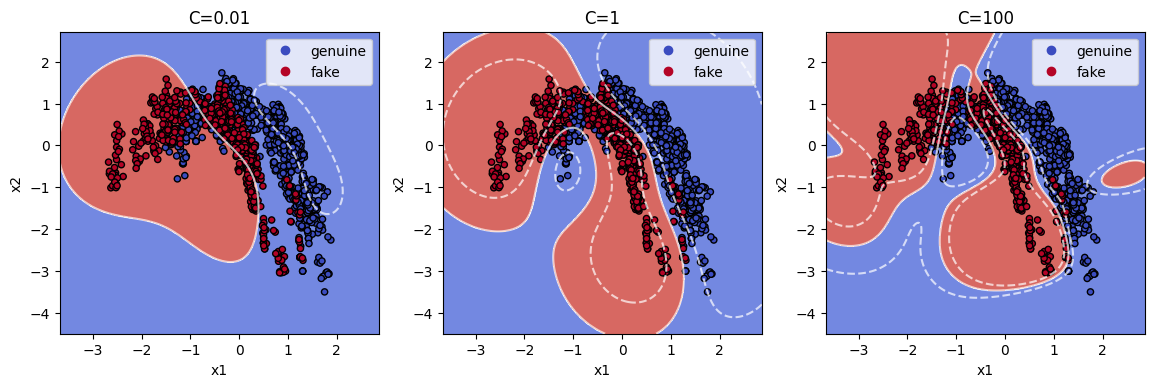

In [16]:
def train_svm(X, y, C):
    svm = SVC(kernel='rbf', C=C)
    return svm.fit(X, y)

C_values = [0.01, 1, 100]
svms = [train_svm(X, y, C) for C in C_values]
titles = [f'C={C}' for C in C_values]

plot_comparison(X, y, svms, titles, margin=True)

📉 For _low_ value of $C$, we can see the margin being _far_ from the decision boundary. This adds more support vectors to shape the border, and effectively _regularizes_ the model. Indeed, the predictions are "less non-linear" than $C=1$. We could argue that the regularization is too strong for $C=0.01$, since it stops correctly predicting the `genuine` cluster around $[-1, 0]$.

📈 For _high_ value of $C$, the margins are squeezed close to the decision boundary. This decreases the number of support vectors, effectively increasing the "power" of the model. Indeed, the decision boundary follows the shape of the few support vectors on the edge of its margin. This also makes the model more sensitive to _noise_. We could argue that the SVM is slightly _overfit_ for $C=100$, because of that small `fake` red "island" around $[2.5, -1]$.

👌 Consequently, we'll keep the default value of $C=1$, which seems a good balance between underfitting and overfitting.

ℹ️ This way of picking $C$ might seem fairly arbitrary... and it is. We'll learn about more scientific and effective methods to choose optimal hyperparameters in the course chapter 4 about machine learning engineering.

### 5.2 Regularization: $\gamma$

In the lecture slides, we briefly mentioned another regularization parameter: gamma ($\gamma$). Recall that a Radial Basis Function creates non-linear features from existing features. It does so by adding features corresponding to the _distances_ to the _support vectors_. 

For example, for a given data point $[-1, 0]$, the RBF kernel would add 617 new features. Each new feature would correspond to the _distance_ to a _support vector_.

$\gamma$ determines the effective _range_ of these new distance features. A large $\gamma$ will reduce the effective range, so only support vectors _close_ to the decision boundary affect it. A small $\gamma$ will increase the effective range, so more support vectors end up changing its shape.

If this sounds confusing, it's because $\gamma$ is a mathematical variable best understood when studying the SVM's cost function equation in its _dual form_. Please check out the additional resources if you are curious about the maths! Otherwise, it doesn't really matter unless you're trying to code an SVM from scratch, and why bother when sklearn provides this beautiful optimized code? 🙃

The visual interpretation of $\gamma$, is that it controls how closely the decision boundary can fit around the individual examples. A high gamma makes the shape of the decision boundary more _local_ , wherease a low gamma makes it more _global_. Therefore high $\gamma$ increase the model _power_ , whereas low $\gamma$ regularizes the model. 

We can show this by comparing classification graphs for different values of $\gamma$:

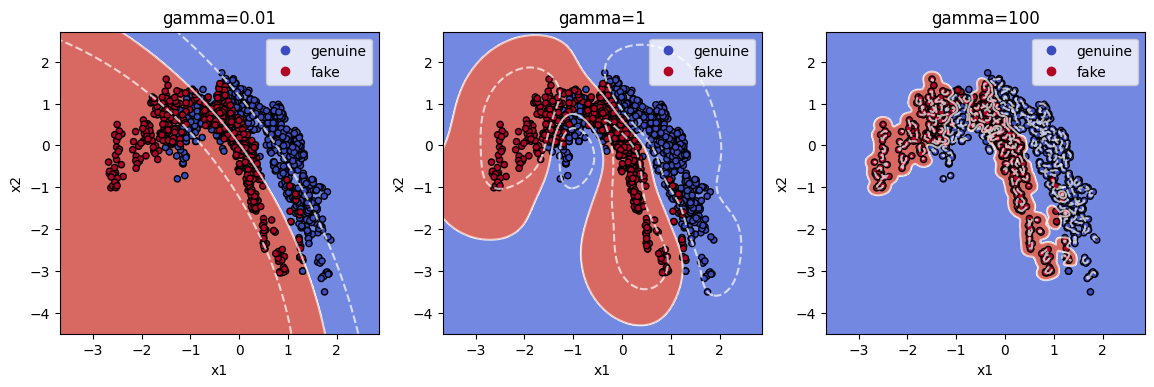

In [17]:
def train_svm(X, y, gamma, C=1):
    svm = SVC(kernel='rbf', C=C, gamma=gamma)
    return svm.fit(X, y)

gamma_values = [0.01, 1, 100]
svms = [train_svm(X, y, gamma) for gamma in gamma_values]
titles = [f'gamma={gamma}' for gamma in gamma_values]

plot_comparison(X, y, svms, titles, margin=True)

📉 For _low_ value of $\gamma$, we can see the regularization effect by how "smooth" the decision boundary is. Support vectors far away contribute to its shape, and they all average out to this smooth surface. As a result, the predictions are "less non-linear" than $\gamma=1$. We could argue that the regularization is too strong for $\gamma=0.01$, since it stops correctly predicting the `genuine` cluster around $[-1, 0]$.

📈 For _high_ value of $\gamma$, we can witness the model's power by how closely the decision boundary fits the data points. Only support vectors very close determine its shape, leading to an irregular and "local" surface. As a result, the predictions are extremely non-linear, and the model sensitive to _noise_. We could argue that the SVM is _overfit_ for $\gamma=100$, and is therefore unlikely to generalize on unseen examples.

👌 Consequently, we'll keep the default value of $\gamma$, which seems a good balance between underfitting and overfitting.

ℹ️ Just like for $C$, this way of picking $\gamma$ isn't very scientific. The best $C$ and $\gamma$ values vary a lot between different datasets, and one must use _hyperparameter optimization_ methods to find the most accurate decision boundary. More on this in chapter 4!

---

We've succesfully fitted a RBF kernel SVM to our banknote dataset, and analysed the effect of hyperparameters $C$ and $\gamma$. The Federal Reserve is very satified with the results. 🎊  Still, recall that we only used two out of four available columns in our original dataset! Let's try this again with the two other features, and see if our SVMs can fit the data better.

💪💪 Train **two** SVMs, one with a linear kernel, and one with a RBF kernel, using the other two available features. Here's a few steps to make sure the unit test passes:
- use the `feature_1` and `feature_3` columns as features, and the `is_fake` column as binary label
- store the feature matrix and label vector in two NumPy `ndarray`s, `X` and `y`
- name your linear kernel `SVC` instance `svm_linear`
- name your RBF kernel `SVC` instance `svm_rbf`
- use `random_state=0` in both `SVC` instances
- don't change the $C$ or $\gamma$ defaults


You are only expected to _fit_ your model. You can then run the cell below to unit test your code, and compare the  SVM decision boundaries.

Once you pass the unit test, feel free to disregard these directions and play around with models / parameters 😜

In [18]:
X = np.asarray(df[['feature_1' , 'feature_3']])

y = np.asarray(df['is_fake'])

#Training linear SVM

svm_linear = SVC(kernel = 'linear' , random_state = 0)

svm_linear = svm_linear.fit(X,y)

#Training RBF SVM

svm_rbf = SVC(kernel = 'rbf' , random_state = 0)

svm_rbf = svm_rbf.fit(X,y) 



Success! 🎉


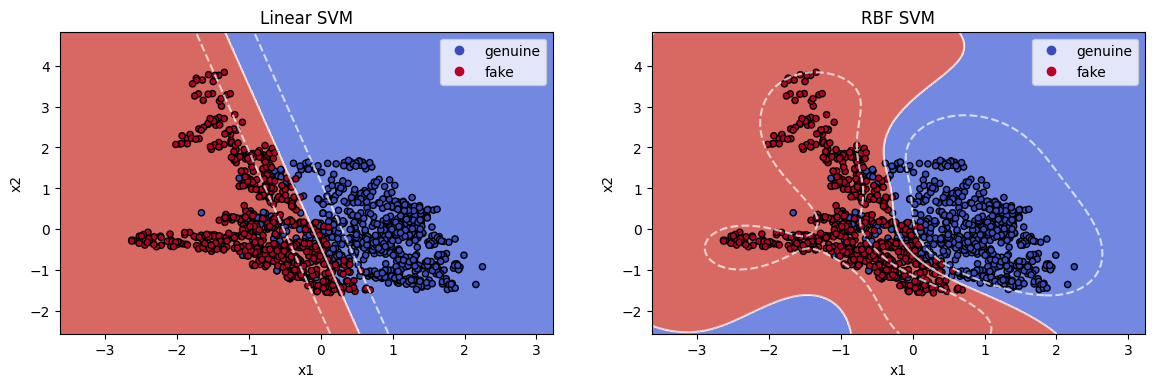

In [19]:
import math

def test_svm():
    assert math.isclose(svm_linear.support_vectors_.sum(), -128.13, rel_tol=1e-4), "Linear SVM model isn't quite as expected"
    assert math.isclose(svm_rbf.support_vectors_.sum(), -156.36, rel_tol=1e-4), "RBF SVM model isn't quite as expected"
    print('Success! 🎉')
    return

test_svm()
plot_comparison(X, y, [svm_linear, svm_rbf], ['Linear SVM', 'RBF SVM'], margin=True)

🧠 Describe the data topology. Is the data linearly separable?

🧠🧠 Compare the predictions of the two models. Is the non-linearity "worth it"? What changed compared to the previous classification task?

Answer : Not perfectly but it does seem to be linearly separable

Answer : The non linearity is not worth it because it's over-fit. we have a weird blue shape while there are no points there. and the model is basically the same except for the weird blue part and the fact that the red boundery is bigger for some reason.


## 6. Summary

Today, we discovered a new type of binary classifier: the **Support Vector Machine**. First, we defined what a **margin** is, and how it relates to model generalization. We then defined SVMs as **large margin classifiers**, and showed how their decision boundary is shaped by a few examples called **support vectors**. We described how SVMs can make **non-linear** predictions through the use of **kernels**, such as the Radial Basis Function kernel. We also acknowledged how SVMs leverage a mathematical technique called the **kernel trick** to efficiently compute these high-dimensional feature spaces. We then compared the pros and cons of SVMs and other classification algorithms. Finally, we applied linear and RBF kernel SVMs to a real dataset in order to detect fake banknotes, and investigated the effect of **regularization** parameters **$C$** and **$\gamma$**.


# Resources

## Core Resources
- [**Slides**](https://docs.google.com/presentation/d/1YHlLETqoquGgoYOZTzHdrZ32cnmZKT0YmnGBr_bYHWI/edit?usp=sharing)
- [Python data science handbook - SVMs](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)  
Great explanations and demonstrations of SVMs with plenty of graphs


## Additional Resources
- [Plotting support vectors in matplotlib](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html)
- [Plotting decision boundaries in matplotlib](https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html)
- [StatQuest - SVMs](https://youtu.be/efR1C6CvhmE)  
Video with great animations going through the theory of SVMs
- [Siraj - building a SVM](https://youtu.be/g8D5YL6cOSE)  
Video coding a SVM from scratch
- [Oxford robotics - SVMs](http://www.robots.ox.ac.uk/~az/lectures/ml/)  
Best mathematical breakdown of the optimization quirks of SVMs.
- [Udemy - the kernel trick](https://youtu.be/N_r9oJxSuRs)  
Video with a high level explanation of the kernel trick